# Regularisation

In this lab we will explore different methods for regularising networks to reduce overfitting and improve generalisation. This uses the material covered in the [fourth lecture slides](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp04-reg.pdf).

# Exercise 1: L1 and L2 penalties

In the previous lab notebook we explored the issue of overfitting. There we saw that this arises when the model is 'too complex' ($\sim$ has too many degrees of freedom / parameters) for the amount of data we have available.

One method for trying to reduce overfitting is therefore to try to decrease the flexibility of the model. We can do this by simply reducing the number of free parameters in the model (e.g. by using a shallower model with fewer layers or layers with smaller dimensionality). More generally however we might want some way of more continuously varying the effective flexibility of a model with a fixed architecture.

A common method for doing this is to add an additional term to the objective function being minimised during training which penalises some measure of the complexity of a model as a function of the model parameters. The aim of training is then to minimise with respect to the model parameters the sum $E^\star$ of the data-driven error function term $\bar{E}$ and a model complexity term $C$.

\begin{equation}
   E^\star =
   \underbrace{\bar{E}}_{\textrm{data term}} + \underbrace{C}_{\textrm{complexity term}}
\end{equation}

We need the complexity term $C$ to be easy to compute and differentiable with respect to the model parameters. A common choice is to use terms involving the *norms* ($\sim$ a measure of size) of the parameters. This penalises models with large parameter values. Two commonly used norms are the L1 and L2 norms. 

For a $D$ dimensional vector $\mathbf{v}$ the L1 norm is defined as

\begin{equation}
\| \boldsymbol{v} \|_1 = \sum_{d=1}^D \left| v_d \right|,
\end{equation}

and the L2 norm is defined as

\begin{equation}
\| \boldsymbol{v} \|_2 = \left[ \sum_{d=1}^D \left( v_d^2 \right) \right]^{\frac{1}{2}}.
\end{equation}

For a $K \times D$ matrix $\mathbf{M}$, we will define norms by collapsing the matrix to a vector $\boldsymbol{m} = \mathrm{vec}\left[\mathbf{M}\right] = \left[ M_{1,1} \dots M_{1,D} ~ M_{2,1} \dots M_{K,D} \right]^{\rm T}$ and then taking the norm as defined above of this resulting vector (practically this just results in summing over two sets of indices rather than one).

The overall complexity penalty term $C$ is defined as a sum over individual complexity terms for each of the $P$ parameters of the model 

\begin{equation}
    C = \sum_{i=1}^P \left[ C^{(i)} \right]
\end{equation}

Some of these per-parameter penalty terms $C^{(i)}$ may be set to zero if we do not wish to penalise the size of the corresponding parameter.

To enable us to tradeoff between the model complexity and data error terms, it is typical to introduce positive scalar coefficients $\beta_i$ to scale the penalty term on the $i$th parameter. A *L1 penalty* on the $i$th vector parameter $\boldsymbol{p}^{(i)}$ (or matrix parameter collapsed to a vector) is then commonly defined as

\begin{equation}
  C^{(i)}_{\textrm{L1}} = 
  \beta_i \left\| \boldsymbol{p}^{(i)} \right\|_1 = 
  \beta_i  \sum_{d=1}^D \left| p^{(i)}_d \right|.
\end{equation}

This has a gradient with respect to the parameter vector

\begin{equation}
  \frac{\partial C^{(i)}_{\textrm{L1}}}{\partial p^{(i)}_d} = \beta_i \, \textrm{sgn}\left( p^{(i)}_d \right)
\end{equation}

where $\textrm{sgn}(u) = +1$ if $u > 0$, $\textrm{sgn}(u) = -1$ if $u < 0$ (and is not well defined for $u=0$ though a common convention is to have $\textrm{sgn}(0) = 0$).

Similarly a *L2 penalty* on the $i$th vector parameter $\boldsymbol{p}^{(i)}$ (or matrix parameter collapsed to a vector) is commonly defined as

\begin{equation}
  C^{(i)}_{\textrm{L2}} = 
  \frac{1}{2} \beta_i \left\| \boldsymbol{p}^{(i)} \right\|_2^2 =
  \frac{1}{2} \beta_i \sum_{d=1}^D \left[ \left( p^{(i)}_d \right)^2 \right].
\end{equation}

Somewhat confusingly this is proportional to the square of the L2 norm rather than the L2 norm itself, however it is an almost universal convention to call this an L2 penalty so we will stick with this nomenclature here. The $\frac{1}{2}$ term is less universal and is sometimes not included; we include it here for consistency with how we defined the sum of squared errors cost. Similarly to that case, the $\frac{1}{2}$ cancels when calculating the gradient with respect to the parameter

\begin{equation}
  \frac{\partial C^{(i)}_{\textrm{L2}}}{\partial p^{(i)}_d} = \beta_i p^{(i)}_d
\end{equation}

Use the above definitions for the L1 and L2 penalties for a parameter and corresponding gradients to implement the `__call__` and `grad` methods respectively for the skeleton `L1Penalty` and `L2Penalty` class definitions below. The `coefficient` property of these classes should be used as the $\beta_i$ value in the equations above. The parameter the penalty term (or gradient) is being evaluated for will be either a one or two-dimensional NumPy array (corresponding to a vector or matrix parameter respectively) and your implementations should be able to cope with both cases.

In [1]:
import numpy as np
seed = 22102017 
rng = np.random.RandomState(seed)
class L1Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L1 norm.
    """
    
    def __init__(self, coefficient):
        """Create a new L1 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L1 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return self.coefficient * abs(parameter).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return np.dot(self.coefficient, parameter/abs(parameter))
    
    def __repr__(self):
        return 'L1Penalty({0})'.format(self.coefficient)
        

class L2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L2 norm.
    """

    def __init__(self, coefficient):
        """Create a new L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return 0.5 * self.coefficient * (parameter**2).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * parameter
    
    def __repr__(self):
        return 'L2Penalty({0})'.format(self.coefficient)

Test your implementations by running the cells below.

In [2]:
test_params_1 = np.array([[0.5, 0.3, -1.2, 5.8], [0.2, -3.1, 4.9, -5.0]])
test_params_2 = np.array([0.8, -0.6, -0.3, 1.5, 2.8])
true_l1_cost_1 = 10.5
true_l1_grad_1 = np.array([[0.5, 0.5, -0.5, 0.5], [0.5, -0.5, 0.5, -0.5]])
true_l1_cost_2 = 3.
true_l1_grad_2 = np.array([0.5, -0.5, -0.5, 0.5, 0.5])
l1 = L1Penalty(0.5)
if (not np.allclose(l1(test_params_1), true_l1_cost_1) or
        not np.allclose(l1(test_params_2), true_l1_cost_2)):
    print('L1Penalty.__call__ giving incorrect value(s).')
elif (not np.allclose(l1.grad(test_params_1), true_l1_grad_1) or 
          not np.allclose(l1.grad(test_params_2), true_l1_grad_2)):
    print('L1Penalty.grad giving incorrect value(s).')
else:
    print('All test values calculated correctly for L1Penalty')

All test values calculated correctly for L1Penalty


In [3]:
test_params_1 = np.array([[0.5, 0.3, -1.2, 5.8], [0.2, -3.1, 4.9, -5.0]])
test_params_2 = np.array([0.8, -0.6, -0.3, 1.5, 2.8])
true_l2_cost_1 = 23.52
true_l2_grad_1 = np.array([[0.25, 0.15, -0.6, 2.9], [0.1, -1.55, 2.45, -2.5]])
true_l2_cost_2 = 2.795
true_l2_grad_2 = np.array([0.4, -0.3, -0.15, 0.75, 1.4])
l2 = L2Penalty(0.5)
if (not np.allclose(l2(test_params_1), true_l2_cost_1) or
        not np.allclose(l2(test_params_2), true_l2_cost_2)):
    print('L2Penalty.__call__ giving incorrect value(s).')
elif (not np.allclose(l2.grad(test_params_1), true_l2_grad_1) or 
          not np.allclose(l2.grad(test_params_2), true_l2_grad_2)):
    print('L2Penalty.grad giving incorrect value(s).')
else:
    print('All test values calculated correctly for L2Penalty')

All test values calculated correctly for L2Penalty


## Exercise 2: Training with regularisation

Previously in the second laboratory you implemented a function `grads_wrt_params`  to calculate the gradient of an error function with respect to the parameters of an affine model (layer), given gradients of the error function with respect to the model (layer) outputs.

If we are training a model using a regularised objective function, we need to additionally calculate the gradients of the regularisation penalty terms with respect to the parameters and add these to the error function gradient terms. Following from the definition of the regularised objective $E^\star$ above we have that the gradient of the overall objective with respect to the $d$th element of the $i$th model parameter is

\begin{equation}
    \frac{\partial E^\star}{\partial p^{(i)}_d} =
    \frac{\partial \bar{E}}{\partial p^{(i)}_d} + 
    \frac{\partial C}{\partial p^{(i)}_d}
\end{equation}

We have already discussed in the second lab notebook how to calculate the error function gradient term $\frac{\partial \bar{E}}{\partial p^{(i)}_d}$. As the model complexity term is composed of a sum of per parameter terms and only one of these will depend on the $i$th parameter we can write

\begin{equation}
    \frac{\partial C}{\partial p^{(i)}_d} = \frac{\partial C^{(i)}}{\partial p^{(i)}_d}
\end{equation}

which corresponds to the penalty term gradients you implemented above. To enable us to use the same `Optimiser` implementation that we have previously used to train models without regularisation, we have altered the implementation of the `AffineLayer` class to allow us to specify penalty terms on the weight matrix and bias vector when creating an instance of the class and to add the corresponding penalty gradients to the returned value from the `grads_wrt_params` method. 

The penalty terms need to be specified as a class matching the interface of the `L1Penalty` and `L2Penalty` classes you implemented above, defining both a `__call__` method to calculate the penalty value for a parameter and a `grad` method to calculate the gradient of the penalty with respect to the parameter. Separate penalties can be specified for the weight and bias parameters, with it common to only regularise the weight parameters. 

The penalty terms for a layer are specifed using the `weights_penalty` and `biases_penalty` arguments to the `__init__` method of the `AffineLayer` class. If either (or both) ofthese are set to `None` (the default) no regularisation is applied to the corresponding parameter.

Using the `L1Penalty` and `L2Penalty` classes you implemented in the previous exercise, train models to classify MNIST digit images with

  * no regularisation
  * an L1 penalty with coefficient $10^{-5}$ on the all of the weight matrix parameters
  * an L1 penalty with coefficient $10^{-3}$ on the all of the weight matrix parameters
  * an L2 penalty with coefficient $10^{-4}$ on the all of the weight matrix parameters
  * an L2 penalty with coefficient $10^{-2}$ on the all of the weight matrix parameters
  
The models should all have three affine layers each interspersed with a `ReluLayer` (as implemented in the Lab 3 on Multiple Layer Models) and intermediate layers between the input and output should have dimensionalities of 100. The final output layer should be an `AffineLayer` (the model outputting the logarithms of the non-normalised class probabilties) and you should use the `CrossEntropySoftmaxError` as the error function (which calculates the softmax of the model outputs to convert to normalised class probabilities before calculating the corresponding multi-class cross entropy error). 

Use the `GlorotInit` class (which implements the weight initialisation technique discussed in the [fifth lecture](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp05-learn.pdf)) to initialise the weights in all layers, using a gain of 0.5 (this adjusts for the fact that the rectified linear sets zeros all negative inputs), and initialises the biases to zero with a `ConstantInit` object. 

As an example the necessary parameter initialisers, model and error can be defined using

```python
weights_init = GlorotUniformInit(0.5, rng)
biases_init = ConstantInit(0.)
input_dim, output_dim, hidden_dim = 784, 10, 100
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, 
                biases_init, weights_penalty=weights_penalty),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, 
                biases_init, weights_penalty=weights_penalty),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, 
                biases_init, weights_penalty=weights_penalty)
])
error = CrossEntropySoftmaxError()
```

This assumes all the relevant classes have been imported from their modules, a penalty object has been assigned to `weights_penalty` and a seeded random number generator assigned to `rng`.

For each regularisation scheme, train the model for 100 epochs with a batch size of 50 and using a gradient descent with momentum learning rule with learning rate 0.01 and momentum coefficient 0.9. For each regularisation scheme you should store the run statistics (output of `Optimiser.train`) and the final values of the first layer weights for each of the trained models.

In [4]:
%load_ext autoreload
%autoreload
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

seed = 24102016 
rng = np.random.RandomState(seed)
batch_size = 50
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)

In [17]:
# set up optimizer parameters
stats_interval = 5
num_epochs = 100

# set up learning rule parameters
learning_rate = 0.01
mom_coeff = 0.9

# set up model parameters
weights_init = GlorotUniformInit(0.5, rng)
biases_init = ConstantInit(0.)
input_dim, output_dim, hidden_dim = 784, 10, 100

error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [18]:
weights_penalties = [
    None,
    L1Penalty(1e-5),
    L1Penalty(1e-3),
    L2Penalty(1e-4),
    L2Penalty(1e-2)
]

run_info = OrderedDict()
models = OrderedDict()

for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: None


Epoch 5: 3.6s to complete
    error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01
Epoch 10: 3.7s to complete
    error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01
Epoch 15: 3.7s to complete
    error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01
Epoch 20: 3.6s to complete
    error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01
Epoch 25: 3.8s to complete
    error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01
Epoch 30: 3.7s to complete
    error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01
Epoch 35: 3.8s to complete
    error(train)=6.40e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01
Epoch 40: 3.7s to complete
    error(train)=5.06e-04, acc(train)=1.00e+00, error(valid)=1.06e-01, acc(valid)=9.79e-01
Epoch 45: 3.7s to complete
    error(train)=4.23e-04, acc

Regularisation: L1Penalty(1e-05)


Epoch 5: 4.8s to complete
    error(train)=6.46e-02, acc(train)=9.82e-01, error(valid)=9.39e-02, acc(valid)=9.73e-01
Epoch 10: 4.8s to complete
    error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=8.04e-02, acc(valid)=9.78e-01
Epoch 15: 4.8s to complete
    error(train)=1.42e-02, acc(train)=9.97e-01, error(valid)=8.12e-02, acc(valid)=9.78e-01
Epoch 20: 4.8s to complete
    error(train)=6.73e-03, acc(train)=9.99e-01, error(valid)=8.81e-02, acc(valid)=9.77e-01
Epoch 25: 4.9s to complete
    error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.79e-02, acc(valid)=9.78e-01
Epoch 30: 4.8s to complete
    error(train)=2.77e-03, acc(train)=1.00e+00, error(valid)=9.02e-02, acc(valid)=9.78e-01
Epoch 35: 4.8s to complete
    error(train)=2.19e-03, acc(train)=1.00e+00, error(valid)=8.69e-02, acc(valid)=9.79e-01
Epoch 40: 5.2s to complete
    error(train)=2.16e-03, acc(train)=1.00e+00, error(valid)=8.94e-02, acc(valid)=9.79e-01
Epoch 45: 5.0s to complete
    error(train)=1.91e-03, acc

Regularisation: L1Penalty(0.001)


Epoch 5: 4.4s to complete
    error(train)=2.53e-01, acc(train)=9.31e-01, error(valid)=2.40e-01, acc(valid)=9.35e-01
Epoch 10: 4.6s to complete
    error(train)=2.20e-01, acc(train)=9.35e-01, error(valid)=2.13e-01, acc(valid)=9.38e-01
Epoch 15: 4.5s to complete
    error(train)=2.28e-01, acc(train)=9.34e-01, error(valid)=2.17e-01, acc(valid)=9.37e-01
Epoch 20: 4.6s to complete
    error(train)=2.70e-01, acc(train)=9.19e-01, error(valid)=2.54e-01, acc(valid)=9.22e-01
Epoch 25: 4.6s to complete
    error(train)=2.34e-01, acc(train)=9.29e-01, error(valid)=2.31e-01, acc(valid)=9.29e-01
Epoch 30: 4.6s to complete
    error(train)=2.22e-01, acc(train)=9.34e-01, error(valid)=2.13e-01, acc(valid)=9.39e-01
Epoch 35: 4.7s to complete
    error(train)=2.08e-01, acc(train)=9.37e-01, error(valid)=2.00e-01, acc(valid)=9.42e-01
Epoch 40: 4.6s to complete
    error(train)=2.01e-01, acc(train)=9.39e-01, error(valid)=1.98e-01, acc(valid)=9.39e-01
Epoch 45: 4.7s to complete
    error(train)=2.03e-01, acc

Regularisation: L2Penalty(0.0001)


Epoch 5: 3.9s to complete
    error(train)=6.49e-02, acc(train)=9.81e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01
Epoch 10: 3.9s to complete
    error(train)=2.65e-02, acc(train)=9.93e-01, error(valid)=8.14e-02, acc(valid)=9.78e-01
Epoch 15: 3.9s to complete
    error(train)=1.41e-02, acc(train)=9.97e-01, error(valid)=8.20e-02, acc(valid)=9.78e-01
Epoch 20: 4.0s to complete
    error(train)=6.66e-03, acc(train)=9.99e-01, error(valid)=8.53e-02, acc(valid)=9.78e-01
Epoch 25: 3.9s to complete
    error(train)=3.56e-03, acc(train)=1.00e+00, error(valid)=8.34e-02, acc(valid)=9.79e-01
Epoch 30: 3.9s to complete
    error(train)=2.80e-03, acc(train)=1.00e+00, error(valid)=8.27e-02, acc(valid)=9.79e-01
Epoch 35: 4.0s to complete
    error(train)=2.53e-03, acc(train)=1.00e+00, error(valid)=8.15e-02, acc(valid)=9.80e-01
Epoch 40: 3.9s to complete
    error(train)=2.44e-03, acc(train)=1.00e+00, error(valid)=8.21e-02, acc(valid)=9.79e-01
Epoch 45: 4.0s to complete
    error(train)=2.29e-03, acc

Regularisation: L2Penalty(0.01)


Epoch 5: 3.8s to complete
    error(train)=2.36e-01, acc(train)=9.41e-01, error(valid)=2.21e-01, acc(valid)=9.45e-01
Epoch 10: 3.7s to complete
    error(train)=2.13e-01, acc(train)=9.45e-01, error(valid)=1.99e-01, acc(valid)=9.52e-01
Epoch 15: 3.8s to complete
    error(train)=2.22e-01, acc(train)=9.44e-01, error(valid)=2.08e-01, acc(valid)=9.48e-01
Epoch 20: 4.1s to complete
    error(train)=2.15e-01, acc(train)=9.46e-01, error(valid)=2.03e-01, acc(valid)=9.49e-01
Epoch 25: 4.0s to complete
    error(train)=2.14e-01, acc(train)=9.47e-01, error(valid)=2.03e-01, acc(valid)=9.50e-01
Epoch 30: 3.8s to complete
    error(train)=2.03e-01, acc(train)=9.50e-01, error(valid)=1.91e-01, acc(valid)=9.55e-01
Epoch 35: 3.8s to complete
    error(train)=2.11e-01, acc(train)=9.47e-01, error(valid)=2.01e-01, acc(valid)=9.50e-01
Epoch 40: 3.8s to complete
    error(train)=2.01e-01, acc(train)=9.50e-01, error(valid)=1.91e-01, acc(valid)=9.54e-01
Epoch 45: 3.8s to complete
    error(train)=2.01e-01, acc

Plot the training set error against epoch number for all different regularisation schemes on the same axis. On a second axis plot the validation set error against epoch number for all the different regularisation schemes. Interpret and comment on what you see.

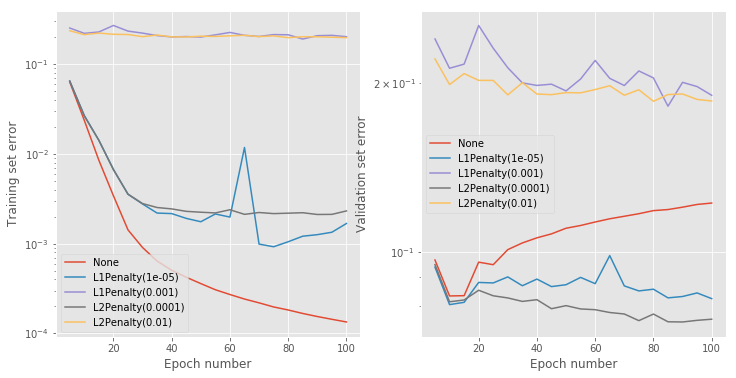

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

The cell below defines two functions for visualising the first layer weights of the models trained above. The first plots a histogram of the weight values and the second plots the first layer weights as feature maps, i.e. each row of the first layer weight matrix (corresponding to the weights going from the input MNIST image to a particular first layer output) is visualised as a $28\times 28$ image. In these feature maps white corresponds to negative weights, black to positive weights and grey to weights close to zero. 

Use these functions to plot a histogram and feature map visualisation for the first layer weights of each model trained above. You should try to interpret the plots in the context of what you were told in the lecture about the behaviour of L1 versus L2 regularisation.

In [26]:
def plot_param_histogram(param, fig_size=(6, 3), interval=[-1.5, 1.5]):
    """Plots a normalised histogram of an array of parameter values."""
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.hist(param.flatten(), 50, interval, normed=True)
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('Normalised frequency density')
    return fig, ax

def visualise_first_layer_weights(weights, fig_size=(5, 5)):
    """Plots a grid of first layer weights as feature maps."""
    fig = plt.figure(figsize=fig_size)
    num_feature_maps = weights.shape[0]
    grid_size = int(num_feature_maps**0.5)
    max_abs = np.abs(model.params[0]).max()
    tiled = -np.ones((30 * grid_size, 
                      30 * num_feature_maps // grid_size)) * max_abs
    for i, fm in enumerate(model.params[0]):
        r, c = i % grid_size, i // grid_size
        tiled[1 + r * 30:(r + 1) * 30 - 1, 
              1 + c * 30:(c + 1) * 30 - 1] = fm.reshape((28, 28))
    ax = fig.add_subplot(111)
    max_abs = np.abs(tiled).max()
    ax.imshow(tiled, cmap='Greys', vmin=-max_abs, vmax=max_abs)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    return fig, ax

Regularisation: None


/afs/inf.ed.ac.uk/user/s18/s1837296/miniconda3/envs/mlp/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


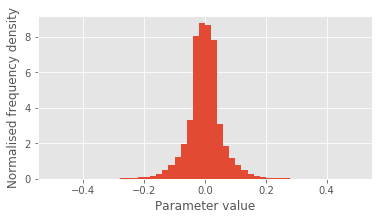

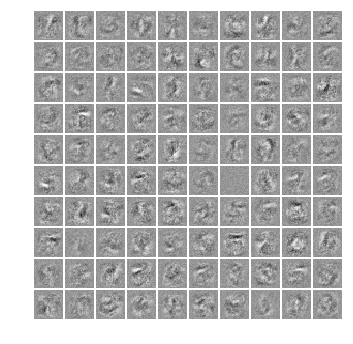

Regularisation: L1Penalty(1e-05)


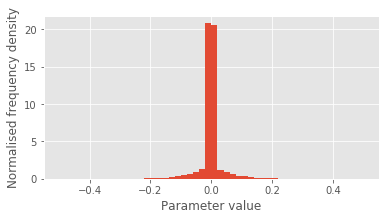

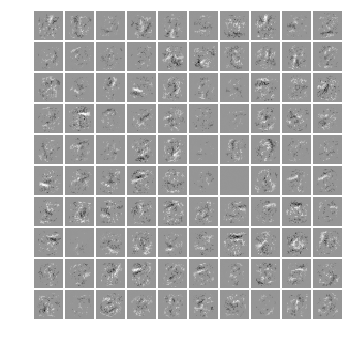

Regularisation: L1Penalty(0.001)


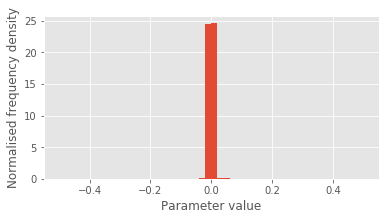

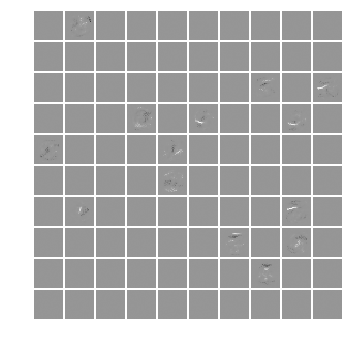

Regularisation: L2Penalty(0.0001)


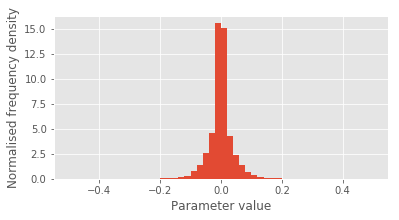

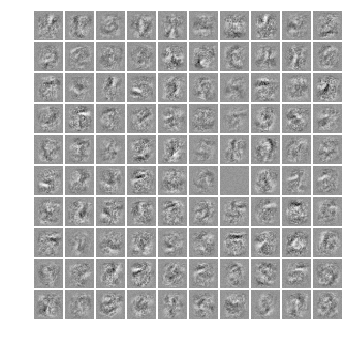

Regularisation: L2Penalty(0.01)


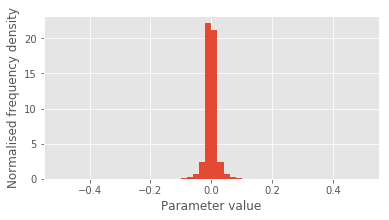

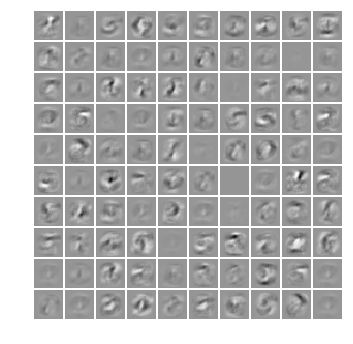

In [27]:
for weight_penalty, model in models.items():
    print('Regularisation: {0}'.format(weight_penalty))
    _ = plot_param_histogram(model.params[0], interval=[-0.5, 0.5])
    _ = visualise_first_layer_weights(model.params[0])

## Exercise 3: Random data augmentation

Another technique mentioned in the lectures for trying to reduce overfitting is to artificially augment the training data set by performing random transformations to the original training data inputs. The idea is to produce further artificial inputs corresponding to the same target class as the original input. The closer the artificially generated inputs are to the appearing like the true inputs the better as they provide more realistic additional examples for the model to learn from.

For the handwritten image inputs in the MNIST dataset, an obvious way to considering augmenting the dataset is to apply small rotations to the original images. Providing the rotations are small we would generally expect that what we would identify as the class of a digit image will remain the same.

Implement a function which given a batch of MNIST images as 784-dimensional vectors, i.e. an array of shape `(batch_size, 784)`

  * chooses 25% of the images in the batch at random
  * for each image in the 25% chosen, rotates the image by a random angle in $\left[-30^\circ,\,30^\circ\right]$
  * returns a new array of size `(batch_size, 784)` in which the rows corresponding to the 25% chosen images are the vectors corresponding to the new randomly rotated images, while the remaining rows correspond to the original images.
  
You will need to make use of the [`scipy.ndimage.interpolation.rotate`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.interpolation.rotate.html#scipy.ndimage.interpolation.rotate) function which is imported below for you. For computational efficiency you should use bilinear interpolation by setting `order=1` as a keyword argument to this function rather than using the default of bicubic interpolation. Additionally you should make sure the original shape of the images is maintained by passing a `reshape=False` keyword argument.

In [ ]:
from scipy.ndimage.interpolation import rotate

def random_rotation(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    raise NotImplementedError()

Use the cell below to test your implementation. This uses the `show_batch_of_images` function we implemented in the first lab notebook to visualise the images in a batch before and after application of the random rotation transformation.

In [ ]:
from mlp.data_providers import MNISTDataProvider
import matplotlib.pyplot as plt
def show_batch_of_images(img_batch, fig_size=(3, 3)):
    fig = plt.figure(figsize=fig_size)
    batch_size, im_height, im_width = img_batch.shape
    # calculate no. columns per grid row to give square grid
    grid_size = int(batch_size**0.5)
    # intialise empty array to tile image grid into
    tiled = np.empty((im_height * grid_size, 
                      im_width * batch_size // grid_size))
    # iterate over images in batch + indexes within batch
    for i, img in enumerate(img_batch):
        # calculate grid row and column indices
        r, c = i % grid_size, i // grid_size
        tiled[r * im_height:(r + 1) * im_height, 
              c * im_height:(c + 1) * im_height] = img
    ax = fig.add_subplot(111)
    ax.imshow(tiled, cmap='Greys') #, vmin=0., vmax=1.)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    return fig, ax

test_data = MNISTDataProvider('test', 100, rng=rng)
inputs, targets = test_data.next()
_ = show_batch_of_images(inputs.reshape((-1, 28, 28)))
transformed_inputs = random_rotation(inputs, rng)
_ = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)))

## Exercise 4: Training with data augmentation

One simple way to use data augmentation is to just statically augment the training data set - for example we could iterate through the training dataset applying a transformation function like that implemented above to generate new artificial inputs, and use both the original and newly generated data in a new data provider object. We are quite limited however in how far we can augment the dataset by with a static method like this however - if we wanted to apply 9 random rotations to each image in the original datase, we would end up with a dataset with 10 times the memory requirements and that would take 10 times as long to run through each epoch.

An alternative is to randomly augment the data on the fly as we iterate through the data provider in each epoch. In this method a new data provider class can be defined that inherits from the original data provider to be augmented, and provides a new `next` method which applies a random transformation function like that implemented in the previous exercise to each input batch before returning it. This method means that on every epoch a different set of training examples are provided to the model and so in some ways corresponds to an 'infinite' data set (although the amount of variability in the dataset will still be significantly less than the variability in all possible digit images). Compared to static augmentation, this dynamic augmentation scheme comes at the computational cost of having to apply the random transformation each time a new batch is provided. We can vary this overhead by changing the proportion of images in a batch randomly transformed.

An implementation of this scheme has been provided for the MNIST data set in the `AugmentedMNISTDataProvider` object in the `mlp.data_providers` module. In addition to the arguments of the original `MNISTDataProvider.__init__` method, this additional takes a `transformer` argument, which should be a function which takes as arguments an inputs batch array and a random number generator object, and returns an array corresponding to a random transformation of the inputs. 

Train a model with the same architecture as in exercise 3 and with no L1 / L2 regularisation using a training data provider which randomly augments the training images using your `random_rotation` transformer function. Plot the training and validation set errors over the training epochs and compare this plot to your previous results from exercise 3. 

In [ ]:
from mlp.data_providers import AugmentedMNISTDataProvider

aug_train_data = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_rotation)